In [15]:
import datetime
from csbdeep.io import load_training_data
from csbdeep.utils import axes_dict, plot_some
import matplotlib.pyplot as plt
from actin_tubules_sim.models import DFCAN
from actin_tubules_sim.loss import mse_ssim
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks


In [11]:
root_dir = '/Users/vkapoor/Downloads/Microtubules'
train_data_file = f'{root_dir}/Train/SR/microtubule_sr_training_data.npz'
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [23]:
(X,Y), (X_val,Y_val), axes = load_training_data(train_data_file, validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]
X = tf.squeeze(X, axis=-1)
X_val = tf.squeeze(X_val, axis=-1)
Y = tf.squeeze(Y, axis=-1)
Y_val = tf.squeeze(Y_val, axis=-1)
X = tf.transpose(X, perm=[0, 2, 3, 1])
X_val = tf.transpose(X_val, perm=[0, 2, 3, 1])

Y = tf.transpose(Y, perm=[0, 2, 3, 1])

Y_val = tf.transpose(Y_val, perm=[0, 2, 3, 1])




number of training images:	 495
number of validation images:	 55
image size (3D):		 (9, 128, 128)
axes:				 SZYXC
channels in / out:		 1 / 1


In [27]:
X.shape,Y.shape,X_val.shape

(TensorShape([495, 128, 128, 9]),
 TensorShape([495, 256, 256, 1]),
 TensorShape([55, 128, 128, 9]))

Text(0.5, 0.98, '5 example validation patches (top row: source, bottom row: target)')

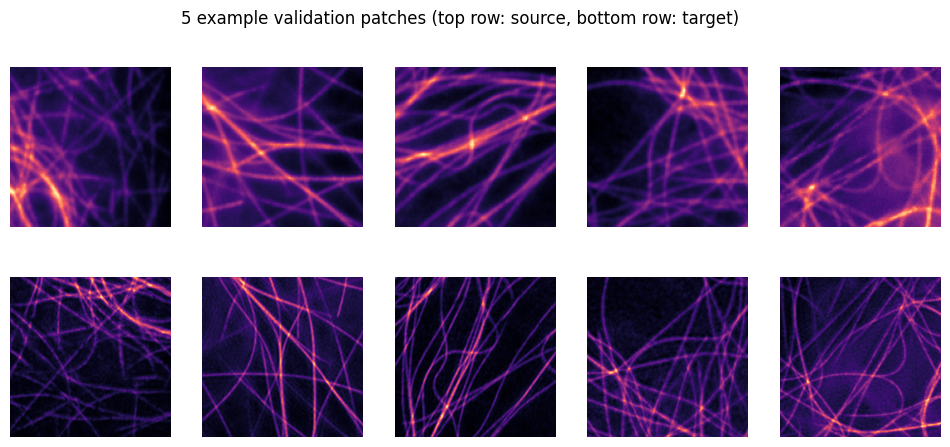

In [34]:
plt.figure(figsize=(12,5))
plot_some(tf.transpose(X_val[:5], perm=[0, 3, 2, 1]),Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)')

In [35]:
init_lr = 1e-4
batch_size = 3
epochs = 10
beta_1=0.9
beta_2=0.999
scale_gt = 2.0

total_data,  height, width, channels= X.shape

In [ ]:
Trainingmodel = DFCAN((height, width, channels), scale=scale_gt)
optimizer = Adam(learning_rate=init_lr, beta_1=beta_1, beta_2=beta_2)
Trainingmodel.compile(loss=mse_ssim, optimizer=optimizer)
Trainingmodel.summary()

tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
lrate = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, verbose=1)
hrate = callbacks.History()


## Training
Training the model will likely take some time. We recommend to monitor the progress with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard), which allows you to inspect the losses during training.

You can start TensorBoard from the current working directory with `tensorboard --logdir=.` Then connect to http://localhost:6006/ with your browser.

In [37]:
Trainingmodel.fit(X, Y, batch_size=batch_size,
                               epochs=epochs, validation_data=(X_val, Y_val), shuffle=True,
                               callbacks=[lrate, hrate, tensorboard_callback])

Epoch 1/10
Tensor("model_4/lambda_413/mul_1:0", shape=(3, 128, 128, 256), dtype=float32),2.0
Tensor("model_4/lambda_413/mul_1:0", shape=(3, 128, 128, 256), dtype=float32),2.0
165/165 [==============================] - 1025s 6s/step - loss: 0.0715 - val_loss: 0.0424 - lr: 1.0000e-04
Epoch 2/10
165/165 [==============================] - 1095s 7s/step - loss: 0.0317 - val_loss: 0.0293 - lr: 1.0000e-04
Epoch 3/10
 91/165 [===============>..............] - ETA: 7:29 - loss: 0.0256

In [ ]:
Trainingmodel.save(root_dir)